# Calculation of the MIZ width
Following Strong et al., *J. Atmos. Ocean. Tech.* (2017) [https://doi.org/10.1175/JTECH-D-16-0171.1], we calculate the MIZ width while maintaing:
- invariance with respect to translation and rotation on the sphere,
- uniqueness at every point in the MIZ, and 
- generality, including nonconvex shapes.

In [251]:
import intake
from intake import cat
# from datatree import DataTree, map_over_subtree

from dask.distributed import Client
import glob
import xarray as xr
import numpy as np
from datetime import timedelta
import cf_xarray as cfxr
import xesmf
import re

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean.cm as cmo
import matplotlib.lines as mlines
import cartopy.feature as cft
import seaborn as sns
from cycler import cycler

# Import my functions
functions_path = os.path.abspath("/home/566/nd0349/access-om3-analysis/functions")
if functions_path not in sys.path:
    sys.path.append(functions_path)
from get_files import *
from plot_settings import *
from fstd import *
from attenuation_models import *
test()
sns.set_style("ticks")
colors = sns.color_palette("colorblind")
plt.rcParams['axes.prop_cycle'] = cycler(color=colors)
𝜋 = np.pi
PUNY = 1e-11

Functions from get_files.py imported!


### Import data using intake

In [220]:
from access_nri_intake.source import builders

builders.__all__

import os
import time

model = 'access-om3'
experiment = "IC4M8-MCW-100km_jra_ryf"
directory = "archive" # "archive" or "work"

PATH = f"/scratch/ps29/nd0349/{model}/{directory}/{experiment}"  # Example ACCESS-OM2 output
datastore_name = f"datastore_{model}_{experiment}.json"  # adjust if builder saves differently

if not os.path.exists(datastore_name):
    start = time.time()
    
    builder = builders.AccessOm3Builder(path=PATH).build()
    builder.save(
        name=datastore_name, 
        description="An example datastore for ACCESS-OM3",
    )
    
    elapsed = time.time() - start
    print(f"✅ Datastore built in {elapsed:.2f} seconds.")
else:
    print(f"ℹ️ Datastore {datastore_name} already exists — skipping build.")

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/access_nri_intake/source/utils.py:259: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(


TypeError: unexpected keyword arguments: 'file_format', 'write_kwargs'

In [216]:
from dask.distributed import Client
client = Client(threads_per_worker=1, memory_limit=0)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43013 instead
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
/g/data/xp65/public/apps/med_conda/envs/analysi

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/43013/status,
Dashboard: /proxy/43013/status,Workers: 14
Total threads: 14,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37739,Workers: 0
Dashboard: /proxy/43013/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:45147,Total threads: 1
Dashboard: /proxy/38309/status,Memory: 0 B
Nanny: tcp://127.0.0.1:44473,


In [218]:
import intake

esm_datastore = intake.open_esm_datastore(
    f"./{datastore_name}", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ] # This is important
)

esm_datastore

FileNotFoundError: [Errno 2] No such file or directory: '/home/566/nd0349/datastore_access-om3_IC4M8-MCW-100km_jra_ryf.json'

In [ ]:
%%time
xarray_open_kwargs = {"chunks": {"time": 12, "nj": -1, "ni": -1}}
# var = 'aice'
first_file_id = esm_datastore.df['file_id'].unique()[0]
# ds_cice = esm_datastore_filtered.search(file_id=first_file_id).to_dask(xarray_open_kwargs=xarray_open_kwargs)
cice_files = f"{PATH}/output*/access-om3.cice.1day*.nc"
ds_cice = xr.open_mfdataset(cice_files,
                            combine='by_coords',
                            data_vars='minimal',
                            coords='minimal',
                            compat='override'
                           )

ds_cice["time"] = ds_cice.time.to_pandas() - timedelta(hours=12)
grid_ds = xr.open_dataset('/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc')
grid_ds

# Add grid to dataset
ds_cice.coords['TLON'] = np.degrees(grid_ds['tlon'])
ds_cice.coords['TLAT'] = np.degrees(grid_ds['tlat'])
ds_cice['tarea'] = np.degrees(grid_ds['tarea'])
ds_cice

### Import data simply

In [237]:
# EXPT = "771-MCW_100km_jra_ryf"
EXPT = "IC4M3-MCW-100km_jra_ryf"
# "IC4M3-MCW-100km_jra_ryf"
# PATH = "/scratch/tm70/ek4684/access-om3/work/771-MCW_100km_jra_ryf_IC4"
# PATH = "/scratch/ps29/nd0349/access-om3/work/" + EXPT
PATH = "/scratch/ps29/nd0349/access-om3/archive/" + EXPT + "/output00*"

In [238]:
ds_grid = xr.open_dataset('/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc')

from pathlib import Path

# cice_files = sorted(glob.glob(f"{PATH}/access-om3.cice.r*.nc"))

cice_files = sorted(glob.glob(f"{PATH}/access-om3.cice.1day*.nc"))#[::30]
# cice_files = sorted(glob.glob(f"{PATH}/access-om3.cice_inst*.nc"))
ds_cice = xr.open_mfdataset(cice_files,
                            combine='by_coords',
                            data_vars='minimal',
                            coords='minimal',
                            compat='override'
                           )
ds_cice.attrs['intake_esm_attrs:realm'] = "ice"

ds_cice.coords['TLON'] = np.degrees(ds_grid['tlon'])
ds_cice.coords['TLAT'] = np.degrees(ds_grid['tlat'])
ds_cice['tarea'] = np.degrees(ds_grid['tarea'])
ds_cice['hte'] = ds_grid['hte']
ds_cice['htn'] = ds_grid['htn']

ww3_files = sorted(glob.glob(f"{PATH}/access-om3.ww3.*.nc"))#[::100]
ds_ww3 = xr.open_mfdataset(ww3_files,
                        combine='by_coords',
                        data_vars='minimal',
                        coords='minimal',
                        compat='override'
                        )
ds_ww3.coords['lon'] = ds_ww3['lon']
ds_ww3.coords['lat'] = ds_ww3['lat']
ds_ww3.attrs['intake_esm_attrs:realm'] = "wave"
ds_ww3


<xarray.Dataset> Size: 996MB
Dimensions:  (ny: 300, nx: 360, time: 59, freq: 25)
Coordinates:
  * time     (time) object 472B 1900-01-02 00:00:00 ... 1900-04-01 00:00:00
    lon      (ny, nx) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    lat      (ny, nx) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
Dimensions without coordinates: ny, nx, freq
Data variables: (12/15)
    mapsta   (time, ny, nx) int32 25MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    UAX      (time, ny, nx) float32 25MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    UAY      (time, ny, nx) float32 25MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    ICE      (time, ny, nx) float32 25MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    ICEH     (time, ny, nx) float32 25MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    ICEF     (time, ny, nx) float32 25MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    ...       ...
    T01      (time, ny, nx) float32 25MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    FP0      (time, ny, nx) float32 25MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    THM      (time, ny, nx) float32 25MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    EF       (time, freq, ny, nx) float32 637MB dask.array<chunksize=(1, 25, 300, 360), meta=np.ndarray>
    USSX     (time, ny, nx) float32 25MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    USSY     (time, ny, nx) float32 25MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
Attributes:
    intake_esm_attrs:realm:  wave

In [239]:
# cice_files

## Simple plots

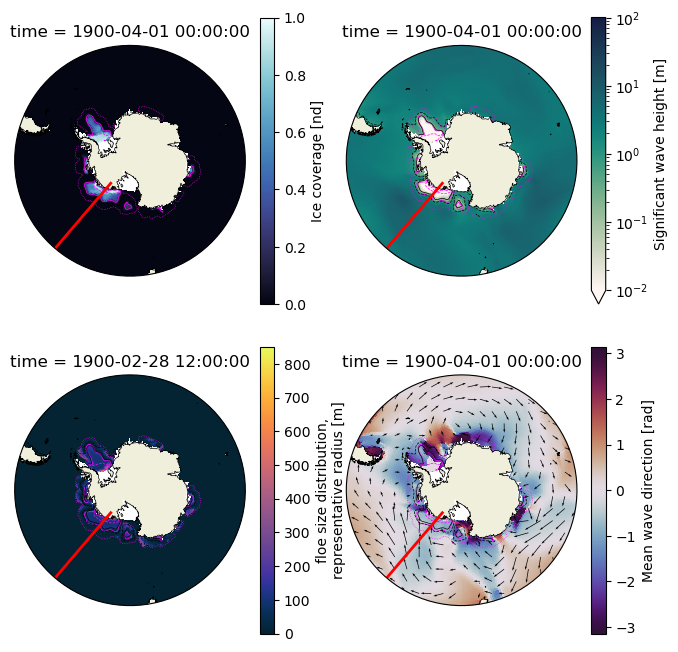

In [240]:
hemisphere = "south"
time_idx = -1
nx_idx = 140

# Slice time
ds_plot = ds_ww3.isel(time=time_idx)
time = ds_plot.time
# ds_plot_cice = ds_cice.sel(time=time, method="nearest")
ds_plot_cice = ds_cice.isel(time=time_idx)
# Setup polar projection
proj = ccrs.SouthPolarStereo()
dims = [2,2]
fig, axes, projection = basic_axis(dims, hemisphere=hemisphere)

# Plot ICE on the map
settings = get_plot_settings("ICE")

ds_plot["ICE"].plot(ax=axes[0], x="lon", y="lat", 
                    cmap=settings.get("cmap"),
                    vmin=settings.get("vmin"),
                    vmax=settings.get("vmax"),
                    transform=ccrs.PlateCarree(),
) 

cs = add_ice_contours(axes[0], ds_plot, hemisphere, projection)


ds_plot["HS"].plot(
    ax=axes[1],
    x="lon",
    y="lat",
    cmap=cmo.tempo,
    norm=mcolors.LogNorm(vmin=1e-2, vmax=100),
    transform=ccrs.PlateCarree(),
)

cs = add_ice_contours(axes[1], ds_plot, hemisphere, projection)
cs2 = add_swh_contours(axes[1], ds_plot, hemisphere, projection)

settings = get_plot_settings("fsdrad")
ds_plot_cice["fsdrad"].plot(ax=axes[2], x="TLON", y="TLAT", 
                    cmap=settings.get("cmap"),
                    vmin=settings.get("vmin"),
                    vmax=settings.get("vmax"),
                    transform=ccrs.PlateCarree(),
) 

cs = add_ice_contours(axes[2], ds_plot, hemisphere, projection)
cs2 = add_swh_contours(axes[2], ds_plot, hemisphere, projection)

# zero degrees representing waves coming from the north
theta_rad = ds_plot["THM"].values #- np.pi #𝜋 # We subtract pi so that 
arrow_mag = ds_plot["HS"].values
U = arrow_mag * np.cos(theta_rad)  # x-component
V = arrow_mag * np.sin(theta_rad)  # y-component

# Subsample the data for plotting arrows (too many arrows can clutter the plot)
stride = 5 
lon_quiver = ds_plot['lon'].values[::stride, ::stride]
lat_quiver = ds_plot['lat'].values[::stride, ::stride]
U_quiver = U[::stride, ::stride]
V_quiver = V[::stride, ::stride]

# Plot background mean direction
ds_plot["THM"].plot(ax=axes[3], x="lon", y="lat", 
                    cmap='twilight_shifted',
                    transform=ccrs.PlateCarree()
)

# Overlay quivers
axes[3].quiver(lon_quiver, lat_quiver, U_quiver, V_quiver,
               transform=ccrs.PlateCarree(),
               scale=100, regrid_shape=20, color='k')

cs = add_ice_contours(axes[3], ds_plot, hemisphere, projection)
cs2 = add_swh_contours(axes[3], ds_plot, hemisphere, projection)

lats = ds_plot["lat"].isel(nx=nx_idx)
lons = ds_plot["lon"].isel(nx=nx_idx)

for ax in axes:
    ax.plot(
        lons, lats,
        color="red",
        linewidth=2,
        transform=ccrs.PlateCarree(),
        label=f"nx={nx_idx}"
    )

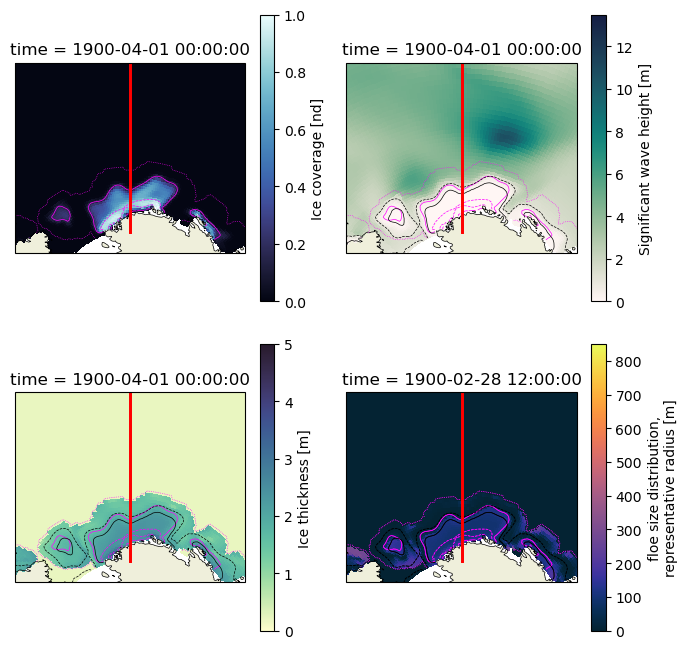

In [241]:
# region_extent = [30, 60, -72, -55]
# nx_idx = best_nx

region_extent = [ds_ww3['lon'].isel(nx=nx_idx)[0].values-30, 
                 ds_ww3['lon'].isel(nx=nx_idx)[0].values+30, 
                 -80, 
                 -50]

# PLOT FOR A REGION
hemisphere = "regional"
shape = "rectangular"
# Slice time
ds_plot = ds_ww3.isel(time=time_idx)

# Setup polar projection
proj = proj = ccrs.Stereographic(central_latitude=(region_extent[2] + region_extent[3])/2, 
                                 central_longitude=(region_extent[0] + region_extent[1])/2)
dims = [2,2]
fig, axes, projection = basic_axis(dims, hemisphere=hemisphere, projection=proj, shape=shape)

# Plot ICE on the map
settings = get_plot_settings("ICE")

ds_plot["ICE"].plot(ax=axes[0], x="lon", y="lat", 
                      # cmap=settings.get("cmap"),
                      # vmin=settings.get("vmin"),
                      # vmax=settings.get("vmax"),
                    cmap=cmo.ice,
                    transform=ccrs.PlateCarree(),
) 

cs = add_ice_contours(axes[0], ds_plot, hemisphere, projection)


ds_plot["HS"].plot(ax=axes[1], x="lon", y="lat", 
                      # cmap=settings.get("cmap"),
                      # vmin=settings.get("vmin"),
                      # vmax=settings.get("vmax"),
                    cmap=cmo.tempo,
                    transform=ccrs.PlateCarree(),
) 

cs = add_ice_contours(axes[1], ds_plot, hemisphere, projection)
cs2 = add_swh_contours(axes[1], ds_plot, hemisphere, projection)


settings = get_plot_settings("hi")
# ds_plot_cice["hi"].plot(ax=axes[2], x="TLON", y="TLAT", 
#                     cmap=settings.get("cmap"),
#                     vmin=settings.get("vmin"),
#                     vmax=settings.get("vmax"),
#                     transform=ccrs.PlateCarree(),
# ) 
ds_plot["ICEH"].plot(ax=axes[2], x="lon", y="lat", 
                    cmap=settings.get("cmap"),
                    vmin=settings.get("vmin"),
                    vmax=settings.get("vmax"),
                    transform=ccrs.PlateCarree(),
) 

cs = add_ice_contours(axes[2], ds_plot, hemisphere, projection)
cs2 = add_swh_contours(axes[2], ds_plot, hemisphere, projection)



settings = get_plot_settings("fsdrad")

ds_plot_cice["fsdrad"].plot(ax=axes[3], x="TLON", y="TLAT", 
                    cmap=settings.get("cmap"),
                    vmin=settings.get("vmin"),
                    vmax=settings.get("vmax"),
                    transform=ccrs.PlateCarree(),
) 

cs = add_ice_contours(axes[3], ds_plot, hemisphere, projection)
cs2 = add_swh_contours(axes[3], ds_plot, hemisphere, projection)

# # zero degrees representing waves coming from the north
# theta_rad = ds_plot["THM"].values # - np.pi #𝜋 # We subtract pi so that 
# arrow_mag = ds_plot["HS"].values
# U = arrow_mag * np.cos(theta_rad)  # x-component (longitude)
# V = arrow_mag * np.sin(theta_rad)  # y-component (latitude)

# # Subsample the data for plotting arrows (too many arrows can clutter the plot)
# stride = 2  # plot every 5th point
# lon_quiver = ds_plot['lon'].values[::stride, ::stride]
# lat_quiver = ds_plot['lat'].values[::stride, ::stride]
# U_quiver = U[::stride, ::stride]
# V_quiver = V[::stride, ::stride]

# Plot background mean direction
# ds_plot["THM"].plot(ax=axes[3], x="lon", y="lat", 
#                     cmap='twilight_shifted',
#                     transform=ccrs.PlateCarree()
# )

# # Overlay quivers
# axes[3].quiver(lon_quiver, lat_quiver, U_quiver, V_quiver,
#                transform=ccrs.PlateCarree(),
#                scale=100, regrid_shape=20, color='k')

# # Compute propagation direction
# theta_rad = ds_plot["THM"].values
# theta_prop = theta_rad + np.pi
# arrow_mag = ds_plot["HS"].values
# U = arrow_mag * np.cos(theta_prop)
# V = arrow_mag * np.sin(theta_prop)

# # Meshgrid for lon/lat
# lon2d, lat2d = np.meshgrid(ds_plot['lon'].values, ds_plot['lat'].values)
# stride = 2
# lon_quiver = lon2d[::stride, ::stride]
# lat_quiver = lat2d[::stride, ::stride]
# U_quiver = U[::stride, ::stride]
# V_quiver = V[::stride, ::stride]

# # Plot quivers
# axes[3].quiver(lon_quiver, lat_quiver, U_quiver, V_quiver,
#                transform=ccrs.PlateCarree(),
#                scale=1, width=0.003, color='k', zorder=10)

cs = add_ice_contours(axes[3], ds_plot, hemisphere, projection)
cs2 = add_swh_contours(axes[3], ds_plot, hemisphere, projection)

# # Add coastlines and grid
# ax.coastlines()
# ax.gridlines(draw_labels=False, linestyle="--", alpha=0.5)

# --- Add red line at nx_idx ---
# If nx is an index along longitude:
lats = ds_plot["lat"].isel(nx=nx_idx)
lons = ds_plot["lon"].isel(nx=nx_idx)

for ax in axes:
    ax.plot(
        lons, lats,
        color="red",
        linewidth=2,
        transform=ccrs.PlateCarree(),
        label=f"nx={nx_idx}"
    )
    # ax.legend()

# plt.legend()
# plt.show()
# Define your region bounds (lon_min, lon_max, lat_min, lat_max)


for ax in axes:
    # Limit to your region in PlateCarree
    ax.set_extent(region_extent, crs=ccrs.PlateCarree())
    
    # Add red line at nx_idx
    ax.plot(
        lons, lats,
        color="red",
        linewidth=2,
        transform=ccrs.PlateCarree(),
        label=f"nx={nx_idx}"
    )

# t = ds_plot['time']
# t_str = np.datetime_as_string(t, unit='D').replace('-', '')
plt.savefig(f"/home/566/nd0349/access-om3-analysis/figures/regional_basic_plot_test.png", dpi=600)
plt.show()

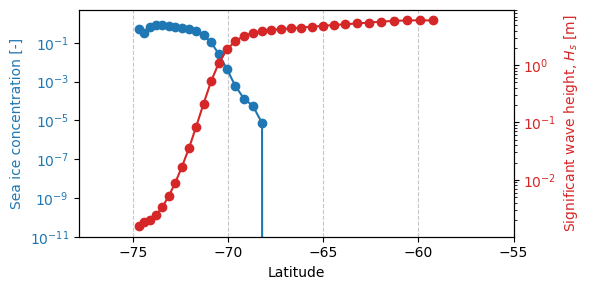

In [242]:
ny_slice=slice(0,45)

fig, ax1 = plt.subplots(1,1, figsize=(6,3))

# Extract transect
ds_transect = ds_ww3.isel(time=time_idx, nx=nx_idx, ny=ny_slice)

# Use latitude for x-axis
x_vals = ds_transect["lat"].values

# First variable: ICE
ax1.plot(x_vals, ds_transect["ICE"].values, color="tab:blue", label="ICE", marker='o')
ax1.set_ylabel("Sea ice concentration [-]", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.set_ylim(PUNY, 5)
ax1.set_yscale('log')

# Second variable: HS (on twin axis)
ax2 = ax1.twinx()
ax2.plot(x_vals, ds_transect["HS"].values, color="tab:red", label="HS", marker='o')
ax2.set_ylabel("Significant wave height, $H_s$ [m]", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")
ax2.set_yscale('log')

# Grid lines
ax1.grid(True, which="both", axis="x", linestyle="--", alpha=0.7)

# Mark ice edges
# ax1.axvline(ds_transect["lat"].values[ice_edge_idx], color='gray', linestyle='-')
# ax1.axvline(ds_transect["lat"].values[p01_ice_edge_idx], color='gray', linestyle='--')
# ax1.axvline(ds_transect["lat"].values[puny_ice_edge_idx], color='gray', linestyle=':')

ax1.set_xlim([x_vals.min(), -55])
ax1.set_xlabel('Latitude')
plt.tight_layout()
plt.show()

## MIZ width

### Simple MIZ width calculation
Simply take a difference in the y-direction of the grid

In [336]:
def _get_mask(ds, definition, hemisphere, threshold=None):
    # Set defaults for each definition
    defaults = {'wave_sig_ht': 0.05, 'aice': 0.8, 'fsdrad': 200}
    if threshold is None:
        try:
            threshold = defaults[definition]
        except KeyError:
            raise ValueError(f"Unknown definition: {definition}")
    
    # Hemisphere mask
    if hemisphere == 'south':
        hemi_mask = ds['TLAT'] < 0
    elif hemisphere == 'north':
        hemi_mask = ds['TLAT'] > 0
    else:
        raise ValueError("hemisphere must be 'north' or 'south'")

    # Base ice presence mask
    base_mask = ds['aice'] > 0.15

    # Definition-specific condition
    if definition == 'wave_sig_ht':
        cond = ds['wave_sig_ht'] > threshold
    elif definition == 'aice':
        cond = ds['aice'] < threshold
    elif definition == 'fsdrad':
        cond = ds['fsdrad'] < threshold
    elif definition in ['SIE', 'SIA']:
        cond = base_mask
    else:
        raise ValueError(f"Unknown definition: {definition}")

    return base_mask & cond & hemi_mask

def _integrate_width(width, ds, method):
    if method == 'simple':
        return width.sum(dim='nj', skipna=True)
    elif method == 'weighted':
        return (width * ds['tmask']).sum(dim='nj', skipna=True)
    else:
        raise ValueError(f"Unknown integration: {method}")

def _reduce_width(width, method, mask):
    if mask:
        width = width.where(width != 0)
    if method == 'median':
        return width.median(dim='ni', skipna=True)
    elif method == 'mean':
        return width.mean(dim='ni', skipna=True)
    else:
        raise ValueError(f"Unknown measure: {method}")

def calculate_miz_width(ds_cice, definition='wave', threshold=0.05, integration='simple', 
                        measure='median', mask=True, method='naive', hemisphere='south'):
    mask_2d = _get_mask(ds_cice, definition, hemisphere, threshold)
    
    if method == 'naive':
        miz_width_2d = ds_cice['hte'].where(mask_2d) / 100 / 1000
        miz_width_1d = _integrate_width(miz_width_2d, ds_cice, integration)
        miz_width_reduced = _reduce_width(miz_width_1d, measure, mask)
    elif method == 'strong':
        print('TODO')

    # # Wrap as xarray DataArray with coordinates
    # if 'ni' in miz_width_reduced.dims:
    #     coords = {'ni': ds_cice['ni']}
    # else:
    #     coords = {}

    return xr.DataArray(
        miz_width_reduced,
        dims=miz_width_reduced.dims,
        coords={'time': ds_cice['time']},
        name='miz_width',
        attrs={
            'units': 'km',
            'description': f'MIZ width ({definition})'
        }
    )

# ds_cice['hte'].where(ds_cice['aice']>0.15).where(ds_cice['TLAT']<0).where(ds_cice['wave_sig_ht']>0.05).isel(time=-1).plot()

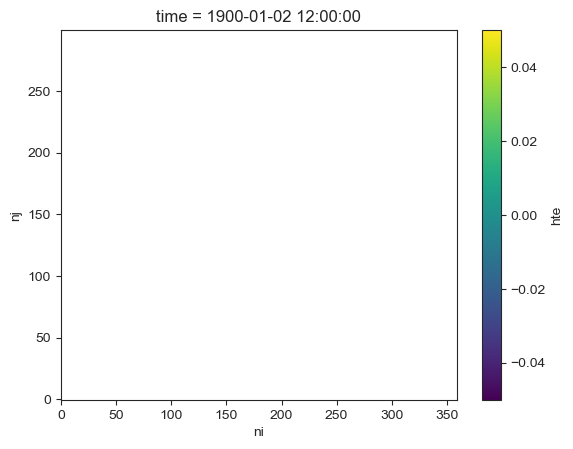

In [337]:
miz_width_2d = ds_cice['hte'].where(ds_cice['aice']>0.15).where(ds_cice['TLAT']<0).where(ds_cice['wave_sig_ht']>0.05)/100 /1000
miz_width_2d.isel(time=1).plot()

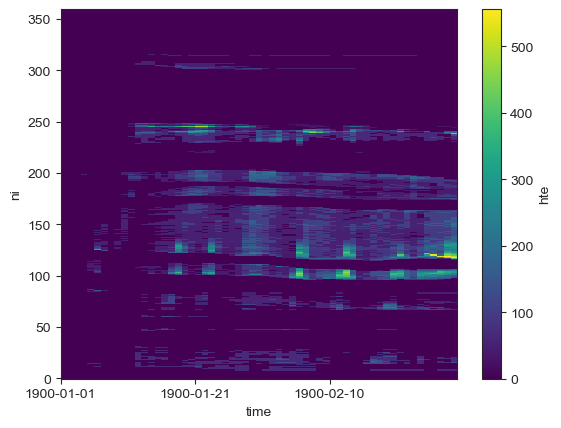

In [338]:
miz_width_1d = miz_width_2d.sum(dim='nj')
miz_width_1d.plot()

Text(0.5, 1.0, 'IC4M3-MCW-100km_jra_ryf')

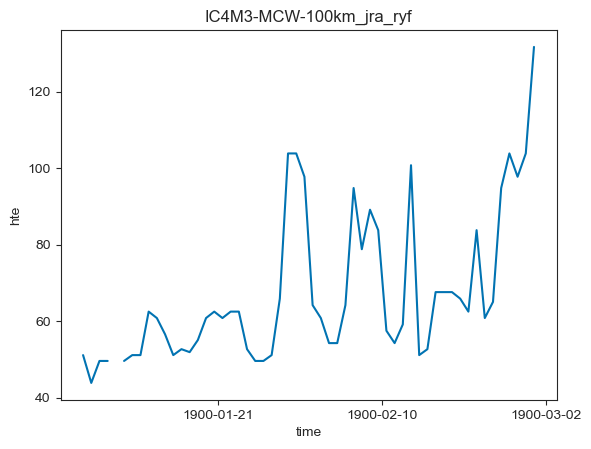

In [339]:
miz_width = miz_width_1d.where(miz_width_1d != 0).median(dim='ni')
miz_width.plot()
plt.title(EXPT)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/dask/_task_spec.py:758: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)


Text(0.5, 1.0, 'IC4M3-MCW-100km_jra_ryf')

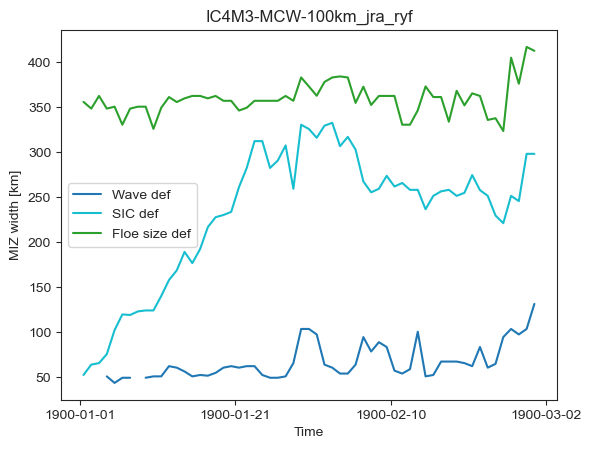

In [340]:
miz_width_wave = calculate_miz_width(ds_cice, definition='wave_sig_ht')
miz_width_aice = calculate_miz_width(ds_cice, definition='aice', threshold=0.8)
miz_width_fsdrad = calculate_miz_width(ds_cice, definition='fsdrad', threshold=200)

miz_width_wave.plot(label='Wave def', color='tab:blue')
miz_width_aice.plot(label='SIC def', color='tab:cyan')
miz_width_fsdrad.plot(label='Floe size def', color='tab:green')
plt.legend()
plt.xlabel('Time')
plt.ylabel('MIZ width [km]')
plt.title(EXPT)

Text(0.5, 1.0, 'IC4M3-MCW-100km_jra_ryf')

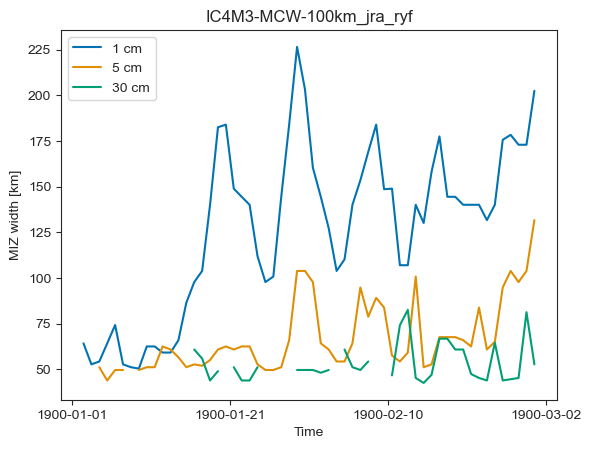

In [341]:
miz_width_wave_1cm = calculate_miz_width(ds_cice, definition='wave_sig_ht', threshold=0.01)
miz_width_wave_5cm = calculate_miz_width(ds_cice, definition='wave_sig_ht', threshold=0.05)
miz_width_wave_30cm = calculate_miz_width(ds_cice, definition='wave_sig_ht', threshold=0.3)

miz_width_wave_1cm.plot(label='1 cm')
miz_width_wave_5cm.plot(label='5 cm')
miz_width_wave_30cm.plot(label='30 cm')
plt.xlabel('Time')
plt.ylabel('MIZ width [km]')
plt.legend()
plt.title(EXPT)

## Sea ice area, extent, and MIZs

In [351]:
def _integrate_area(ds, mask, definition):
    if definition == "SIA":
        return ds['tarea']*ds['aice'].where(mask).sum(dim=['ni' 'nj'])
    else:
        return ds['tarea'].where(mask).sum(dim=['ni' 'nj'])

def calculate_area(ds_cice, definition='wave', threshold=0.05, integration='simple', 
                        measure='median', mask=True, method='naive', hemisphere='south'):
    mask_2d = _get_mask(ds_cice, definition, hemisphere, threshold)
    
    sea_ice_extent = _integrate_area(ds_cice, mask_2d, definition)

    if definition in ["wave_sig_ht", "aice", "fsdrad"]:
        name = "MIZ area"
    elif definition == "SIE":
        name = "Sea ice extent"
    elif definition == "SIA":
        name = "Sea ice area"

    return xr.DataArray(
        sea_ice_area,
        dims=sea_ice_extent.dims,
        coords={'time': ds_cice['time']},
        name=name,
        attrs={
            'units': 'km',
            'description': f'MIZ width ({definition})'
        }
    )


In [352]:
sea_ice_extent = calculate_area(ds_cice, definition='SIE')
sea_ice_area = calculate_area(ds_cice, definition='SIA')
# miz_width_aice = calculate_miz_width(ds_cice, definition='aice', threshold=0.8)
# miz_width_fsdrad = calculate_miz_width(ds_cice, definition='fsdrad', threshold=200)

sea_ice_extent.plot(label='Wave def', color='tab:blue')
sea_ice_area.plot(label='SIC def', color='tab:cyan')
# miz_width_fsdrad.plot(label='Floe size def', color='tab:green')
plt.legend()
plt.xlabel('Time')
plt.ylabel('MIZ width [km]')
plt.title(EXPT)

ValueError: 'ninj' not found in array dimensions ('nj', 'ni', 'time')

In [318]:
miz_area = ds_cice['tarea'].where(ds_cice['aice'] > 0.15).where(ds_cice['fsdrad'] < 200).where(ds_cice['tlat'] < 0)

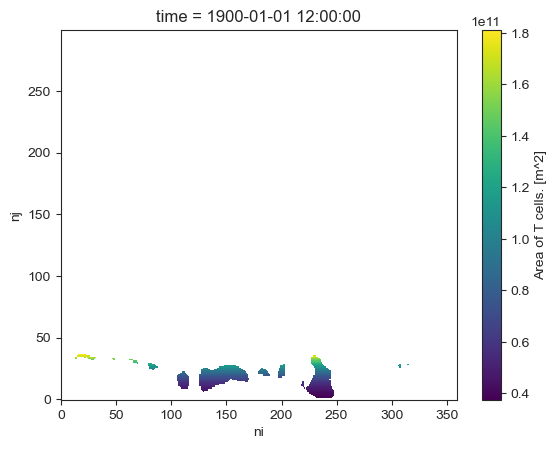

In [319]:
miz_area.isel(time=0).plot()

## Messing around with Strong 2017

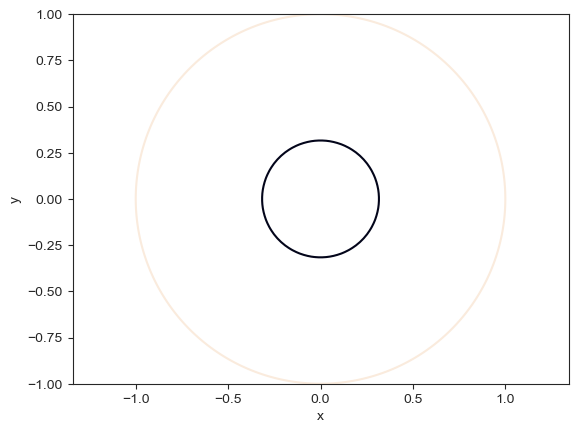

In [277]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
miz_measure = X**2 + Y**2  # equation of a circle

plt.contour(X, Y, miz_measure, levels=[0.1, 1])  # circle with radius 1
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')  # ensures circle is not distorted
plt.show()

In [278]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
miz_measure = X**2 + Y**2

level_low = 0.1
level_high = 1.0

dx = x[1] - x[0]
dy = y[1] - y[0]

mask = (miz_measure >= level_low) & (miz_measure <= level_high)
area_estimate = mask.sum() * dx * dy

print(f"Estimated area on grid: {area_estimate:.6f}")
print(f"Analytic area: {np.pi*(level_high-level_low):.6f}")

Estimated area on grid: 2.814407
Analytic area: 2.827433


In [284]:
import numpy as np
import matplotlib.pyplot as plt

# Create grid and field
x = np.linspace(-1, 1, 200)
y = np.linspace(-1, 1, 200)
X, Y = np.meshgrid(x, y)
miz_measure = X**2 + Y**2

# Levels (squared radii)
levels = [0.1, 1.0]

# Generate contours (no need to close fig)
fig, ax = plt.subplots()
CS = ax.contour(X, Y, miz_measure, levels=levels)
plt.close(fig)

def contour_length_from_allsegs(CS, level_index):
    """Compute perimeter (length) from CS.allsegs for a given level."""
    segs = CS.allsegs[level_index]  # list of arrays of (N,2) vertices
    max_len = 0.0
    for verts in segs:
        diffs = np.diff(verts, axis=0)
        perim = np.hypot(diffs[:,0], diffs[:,1]).sum()
        if not np.allclose(verts[0], verts[-1]):
            perim += np.hypot(*(verts[0] - verts[-1]))
        max_len = max(max_len, perim)
    return max_len

# Compute lengths and store in NumPy array
lengths = np.array([contour_length_from_allsegs(CS, i) for i in range(len(levels))])

# Print results
for level, L in zip(levels, lengths):
    print(f"Contour level = {level:.2f}, length ≈ {L:.6f}")

# lengths now holds the numeric results
print("\nLengths array:", lengths)

Contour level = 0.10, length ≈ 1.986669
Contour level = 1.00, length ≈ 6.283107

Lengths array: [1.98666869 6.28310739]


In [288]:
l_ratio = area_estimate / np.mean(lengths)
l_ratio

0.6806488267456201

In [285]:
lengths

array([1.98666869, 6.28310739])

In [275]:
import numpy as np

def ell(psi_c, alpha, a, R0, x1=0, x2=0):
    psi_ratio = psi_c / alpha
    
    # Handle special cases
    if np.isclose(psi_ratio % (2*np.pi), 0):
        return 1 + x2
    elif np.isclose(psi_ratio % (2*np.pi), np.pi):
        return 1 - x1
    
    # General case
    term = (a**2 - 1) / (a * np.sin(psi_ratio))
    t1 = np.arctan((a * R0 - np.cos(psi_ratio)) / np.sin(psi_ratio))
    t2 = np.arctan((a * 1 - np.cos(psi_ratio)) / np.sin(psi_ratio))
    return term * (t1 - t2)

In [276]:
psi_c = np.pi / 4   # example streamfunction value
alpha = 1.0
a = 1.5
R0 = 2.0

ℓ_value = ell(psi_c, alpha, a, R0)
print(f"ℓ(ψc/α, a) = {ℓ_value:.3f}")

ℓ(ψc/α, a) = 0.506
